In [1]:
import cloudy
import torch
import numpy as np
import vulky.datasets as datasets  # module containing some resources for examples.
import os
import matplotlib.pyplot as plt


pipeline = cloudy.create_pipeline('./test')
# pipeline.download_pretrained()
recorder = pipeline.create_recorder()
ref_latent = pipeline.get_test_latent(8)
ref_grid = pipeline.decode_latent(ref_latent)
ref_grid = pipeline.clean_volume(ref_grid)

settings = dict(
    camera_position = (np.cos(0.5) * 1.3, 2 + np.sin(0.5), np.sin(0.5) * 1.3),
    environment = datasets.Images.environment_example,  # An HDR environment
    density_scale = 300,
    phase_g = 0.0,
    scattering_albedo = (0.95, 0.95, 0.95),
)

def render_grid(g: torch.Tensor, 
                # These parameters are unknown now
                environment, environment_sampler, 
                samples: int = 128):
    return cloudy.scattered(g * settings['density_scale'],
                     camera_poses=cloudy.camera_poses(settings['camera_position']),
                     scattering_albedo=settings['scattering_albedo'],
                     environment=environment,
                     environment_sampler=environment_sampler,
                     phase_g=settings['phase_g'],
                     majorant=g.max() * settings['density_scale'],
                     # kwargs
                     width=512,  # image width in pixels
                     height=512,  # image height in pixels
                     jittered=True,  # rays pass through 
                     samples=samples,  # number of ray paths for the primal evaluation
                     samples_bw=8,  # number of ray paths for the gradients backprop
                     mode='sps'  # singular path-sampling is used instead of DRT.
                     )


/home/leonard/rendervous.project/rdv_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


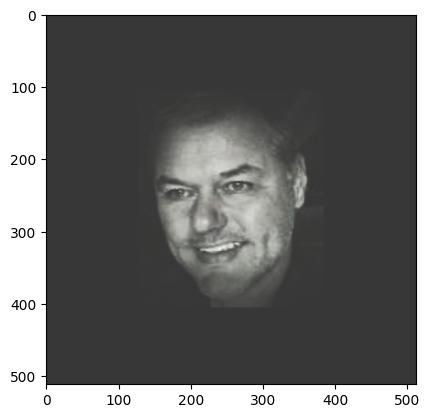

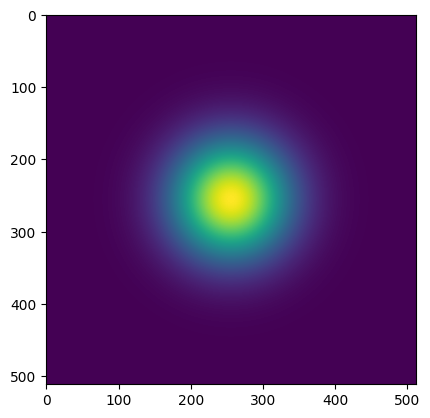

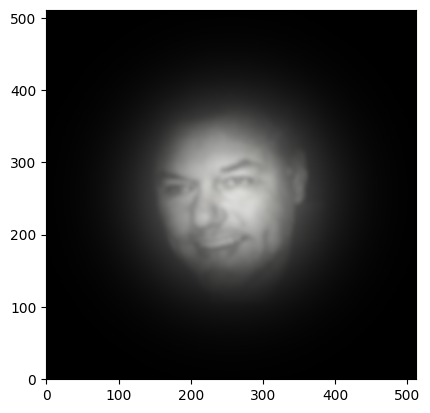

In [2]:
import torchvision

image = torchvision.io.image.read_image('./westermann.jpg').permute(1,2,0).to(pipeline.get_device())/255.0
image = cloudy.resampling(image.unsqueeze(0), (300, 256))[0] * 0.5 + 0.5

reference_image = torch.ones(512, 512, 3, device=pipeline.get_device()) * 0.5
reference_image[128-22:-128+22, 128:-128] = image

reference_image **= 2.2

plt.imshow(reference_image.cpu())
plt.show()

# create a gaussian saliency mask
x = torch.arange(-1.0, 1.000001, 2.0/(511), device=pipeline.get_device())
y = torch.arange(-1.0, 1.000001, 2.0/(511), device=pipeline.get_device())

g = torch.cartesian_prod(y, x)[:, [1,0]]
g = torch.exp(-10*(g[:,0:1]**2 + g[:,1:2]**2)).view(512, 512, 1)
plt.imshow(g.cpu())
plt.show()



reference_image = torch.flip(reference_image, dims=[0])
reference_image = cloudy.gaussian_filter(reference_image.unsqueeze(0), sigma=3.0, kernel_size=11)[0] * g
# reference_image = ((torch.sigmoid((reference_image-0.5)*8 + 0*(g**0.125))) ** (2.2)) * g
plt.imshow(reference_image.cpu() ** (1.0/2.2))
plt.gca().invert_yaxis()
plt.show()

reference_image = reference_image.unsqueeze(0)
g = g.unsqueeze(0)

In [3]:
# environment parameters
environment_parameter = torch.nn.Parameter(torch.ones(16, 32, 3, device=pipeline.get_device())*-4.0, requires_grad=True)
with torch.no_grad():
    environment_parameter[4,16] = np.log(100)
global_parameter = torch.nn.Parameter(torch.ones(1, 1, 3, device=pipeline.get_device())*-4.0, requires_grad=True)

# environment map model
def compute_environment_map():
    return torch.exp(environment_parameter) + torch.sigmoid(global_parameter)

In [4]:
def create_A(samples: int = 64):
    with torch.no_grad():
        # assume current environment map fixed during DPS
        environment_tensor = compute_environment_map()
    environment, environment_sampler = cloudy.environment_objects(environment_tensor)
    return lambda v: render_grid(v, environment, environment_sampler, samples=samples)*g

def create_L(v: torch.Tensor, y: torch.Tensor, samples: int = 64):
    def L():
        e = compute_environment_map()
        yhat = cloudy.scattered_environment(
             environment=e,
             grid=v * settings['density_scale'],
             camera_poses=cloudy.camera_poses(settings['camera_position']),
             majorant=v.max().item() * settings['density_scale'],
             scattering_albedo=settings['scattering_albedo'],
             phase_g=settings['phase_g'],
             width=512,
             height=512,
             jittered=True,
             samples=samples,
             bw_samples=max(1, samples // 8),
             )
        loss = torch.nn.functional.mse_loss(yhat*g, y, reduction='sum')
        loss += 0.1 * cloudy.total_variation_2D(e.unsqueeze(0))
        loss += e.sum()  # Sparsity regularization
        loss += e[8:].sum() * 4.0  # Ground darker
        return loss
    return L

Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda


Unconditional sampling DDIM:  97%|█████████▋| 97/100 [00:02<00:00, 48.10it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


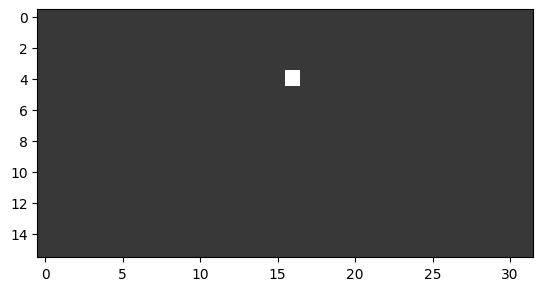

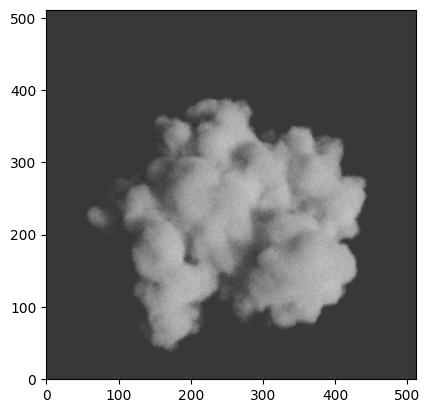

Opt: 100%|█████████▉| 199/200 [02:07<00:00,  1.54it/s, Loss: 7707.31982421875]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


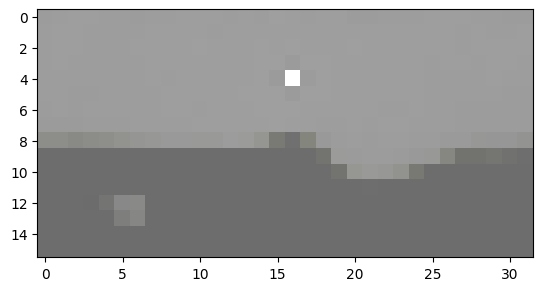

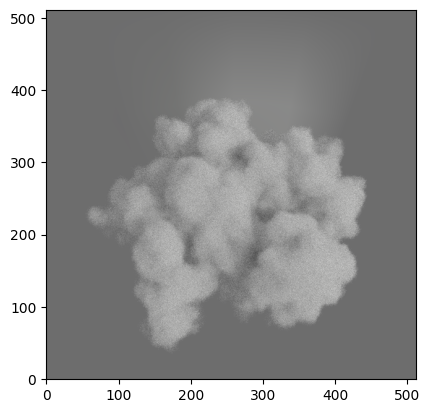

Posterior sampling DPS_DDIM:  99%|█████████▉| 99/100 [01:39<00:01,  1.27s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


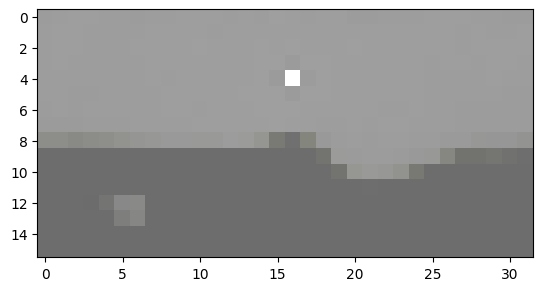

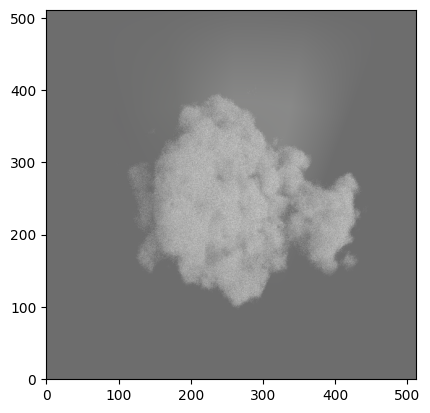

Opt: 100%|█████████▉| 199/200 [02:08<00:00,  1.55it/s, Loss: 2670.550048828125]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


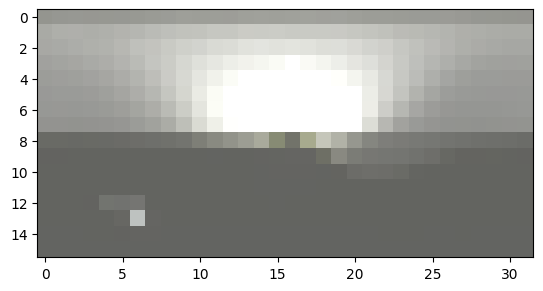

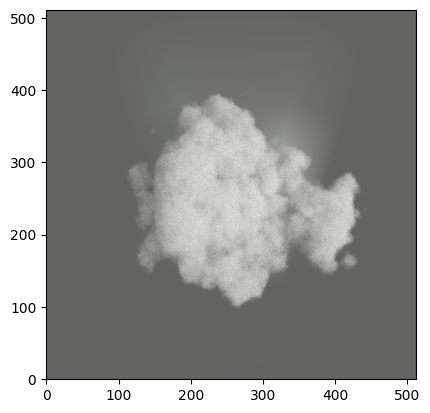

Posterior sampling DPS_DDIM:  99%|█████████▉| 99/100 [02:56<00:02,  2.22s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


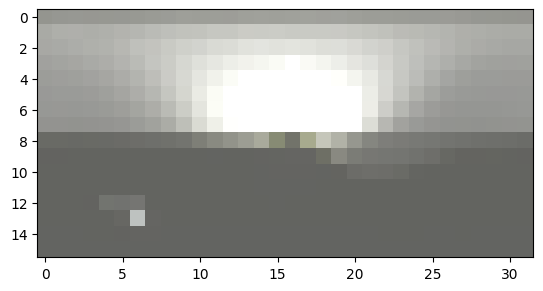

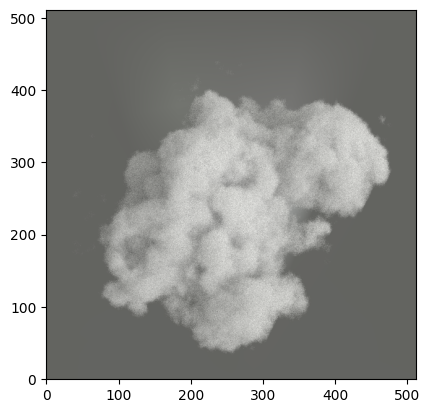

Opt: 100%|█████████▉| 199/200 [02:20<00:00,  1.43it/s, Loss: 1835.0294189453125]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


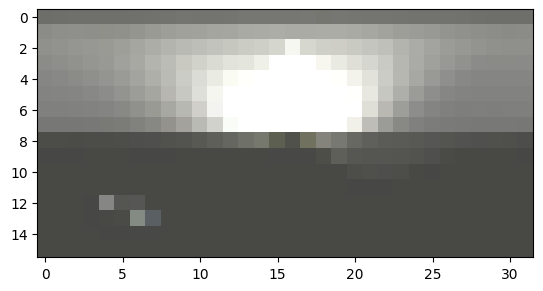

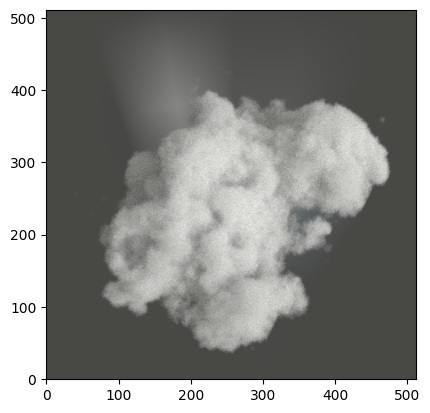

Posterior sampling DPS_DDIM:  99%|█████████▉| 99/100 [03:04<00:02,  2.63s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


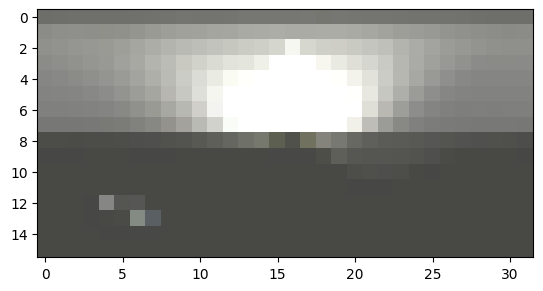

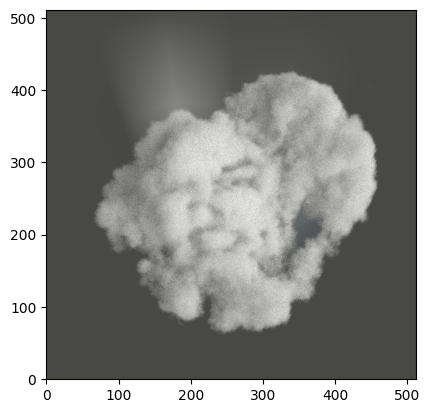

Opt: 100%|█████████▉| 199/200 [02:28<00:00,  1.34it/s, Loss: 1500.2633056640625]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


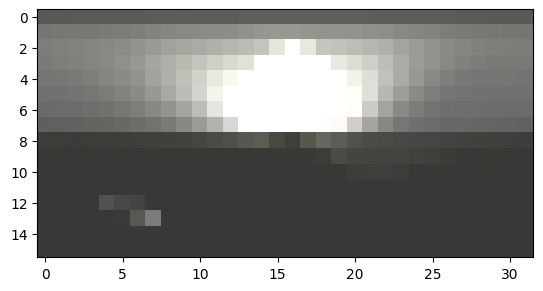

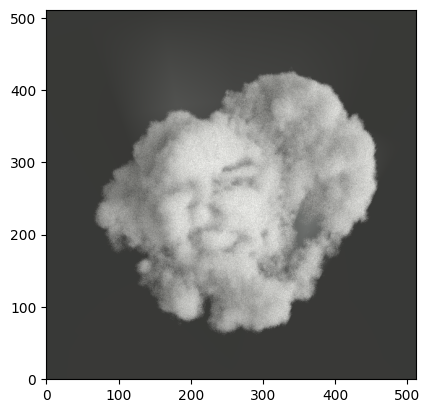

Posterior sampling DPS_DDIM:  99%|█████████▉| 99/100 [03:21<00:02,  2.68s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


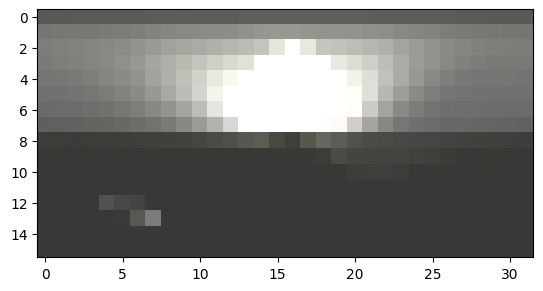

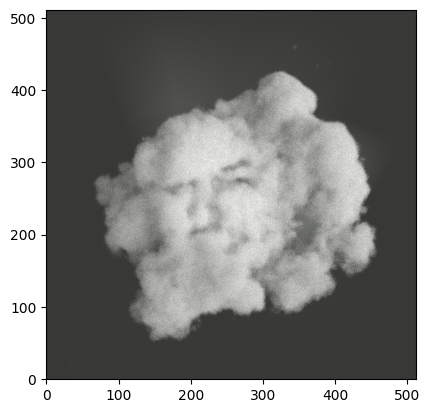

Opt: 100%|█████████▉| 199/200 [02:27<00:00,  1.41it/s, Loss: 1432.1842041015625]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


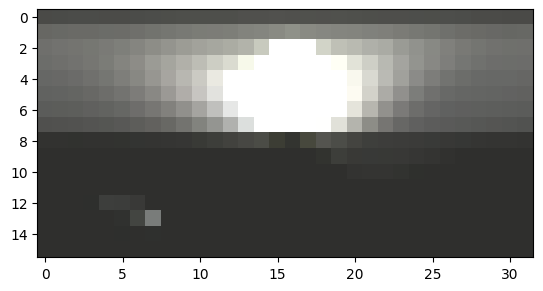

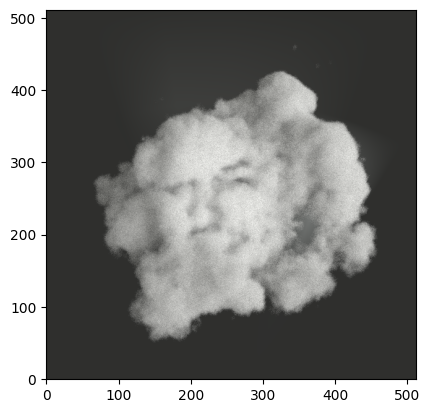

Posterior sampling DPS_DDIM:  99%|█████████▉| 99/100 [04:33<00:02,  3.00s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


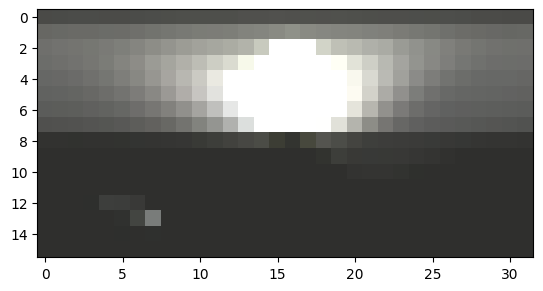

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


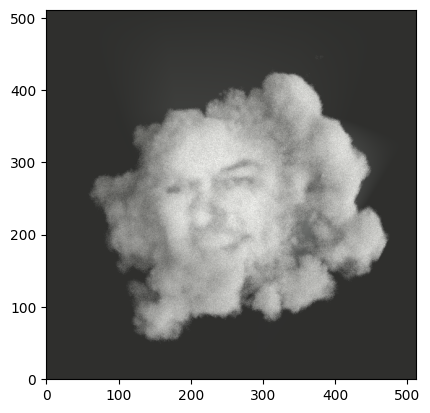

Posterior sampling DPS_DDIM: 100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


In [5]:
opt = torch.optim.NAdam([environment_parameter, global_parameter], lr=0.008)

def callback(ci: cloudy.CallbackInfo):
    if ci.step == ci.total_steps - 1:
        with torch.no_grad():
            b = compute_environment_map()
            plt.imshow(b.cpu() ** (1.0/2.2))
            plt.show()
            
            e, es = cloudy.environment_objects(b)
            r = render_grid(ci.volume(128), e, es, samples=64)
            plt.imshow(r[0].cpu() ** (1.0/2.2))
            plt.gca().invert_yaxis()
            plt.show()

grid = pipeline.reconstruct_volume(
    y = reference_image,
    A_factory = lambda p: create_A(),
    L_factory = lambda p, grid, y: create_L(grid, y),  # no physical parameter unknown
    optimizer=opt,
    resolution=128,
    ema_factor=0.2,
    samples=100,
    scheduler_gamma=.6,
    weights=[0.1, 0.1, 0.2, 0.2, 0.3],
    decoding_resolution=[32, 32, 64, 64, 128],
    decoding_noise=[1.0, 1.0, 1.0, 1.0, 0.0],
    optimization_steps=200,
    optimization_passes=5,
    callback=callback
)

Rendering captures: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


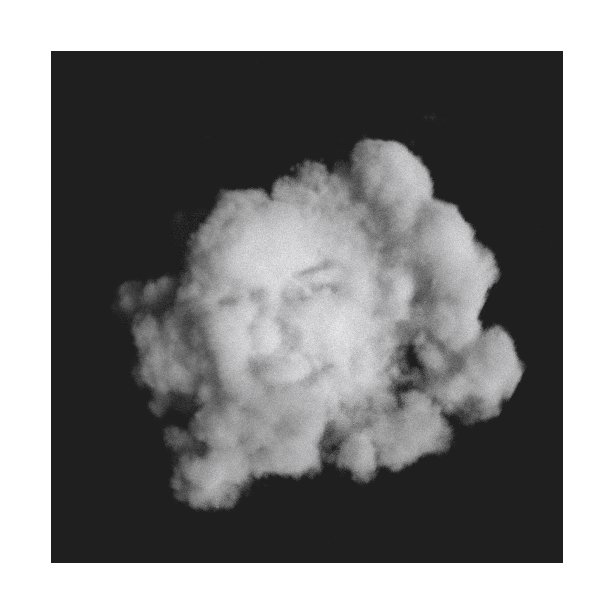

In [15]:
# create a recorder for the transitions
recorder = pipeline.create_recorder()
with torch.no_grad():
    environment = compute_environment_map()
    mask = environment < 10.0
    environment[mask] = 0.01
    environment[mask][2] = 0.02
    environment[~mask] *= 10.0
# saves the grid in the recorder to be used several times
grid_id = recorder.add_volume(grid)
# saves the environment tensor
env_id = recorder.add_environment(environment)
# capture multiple camera poses
recorder.new_keyframe(
    # Novel view for the sampled grid
    recorder.add_capture_volume(grid_id,
                                environment=env_id,
                                camera_position=(np.cos(0.5)*1.3, 2 + np.sin(0.5), np.sin(0.5)*1.3),
                                scattering_albedo=(0.95, 0.95, 0.95), #settings['scattering_albedo'],
                                phase_g=settings['phase_g'],
                                density_scale=settings['density_scale'],
                                samples=128, render_mode='ms')        
)
recorder.show_clip(1)

In [7]:
with torch.no_grad():
    torch.save({'grid': grid, 'settings': settings, 'environment': compute_environment_map() }, './westermann_grid.pt')

In [22]:
recorder = pipeline.create_recorder()
env_id = recorder.add_environment(environment)
grid_id = recorder.add_volume(grid)
for i in range(200):
    x = 1 - 2 * (i / 199)
    alpha = (x**2)*np.sign(x)
    recorder.new_keyframe(recorder.add_capture_volume(
        grid_id,
        env_id,
        camera_position=(np.cos(0.5 + alpha*np.pi) * (abs(alpha) + 1.3), (2 - abs(alpha)) + np.sin(0.5 - alpha*np.pi/2), np.sin(0.5 + alpha*np.pi)* (1.3 + abs(alpha))),
        scattering_albedo=settings['scattering_albedo'],
        samples=128,
        render_mode='ms'
    ))

recorder.save_video('westermann.mp4', samples_multiplier=4)

Rendering captures: 100%|██████████| 200/200 [1:05:02<00:00, 19.51s/it]
